In [1]:
symbol = "AAPL"         # Stock symbol
K_min, K_max = 200, 400 # Strike price range
maturity_days_min, maturity_days_max = 30, 120 # Maturity range
option_type = 'call'    # Option type (call/put)

In [2]:
from numpy import linspace, mean

n = 500 # Number of data points
maturities = linspace(maturity_days_min, maturity_days_max, n) / 365 # Maturity range in years

In [3]:
from data_lib.tradingview import get_risk_free_rate

r = get_risk_free_rate(mean(maturities)) # Risk-free rate from mean of maturities in years

you are using nologin method, data you access may be limited


Selected ticker: US02MY for maturity 0.21 years
Risk-Free Rate: 5.2150%


In [4]:
from yfinance import Ticker
from numpy import log, sqrt, meshgrid
from pandas import Timestamp, Timedelta

ticker = Ticker(symbol)

S = ticker.history(period="1d")['Close'].iloc[-1] # Current stock price from live data

# Historical data if needed for volatility calculation
historical_data = ticker.history(period="1y")['Close']
sigma = log(historical_data / historical_data.shift(1)).dropna().std() * sqrt(252) # Volatility from live data

print(f"Current stock price: {S}")

Current stock price: 229.0


In [9]:
from pandas import DataFrame, concat

df = DataFrame(columns=[ "strike", "impliedVolatility", "maturity"])

for T in maturities:
    
    maturity = Timestamp.now() + Timedelta(days=T*365)
    
    try:
        option_chain = ticker.option_chain(maturity.strftime('%Y-%m-%d'))
    except ValueError:
        continue
    
    match option_type:
        case 'call':
            option_prices = option_chain.calls
        case 'put':
            option_prices = option_chain.puts
    
    _df = option_prices.loc[ (option_prices['strike'] >= K_min) & (option_prices['strike'] <= K_max) ][["strike", "impliedVolatility"]]
    
    _df['maturity'] = T*365
    
    df = concat(
        [df, _df],
        ignore_index=True
    )

C:\Users\j10st\AppData\Local\Temp\ipykernel_33552\4012420282.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = concat(


In [10]:
pivot_table = df.pivot_table(
    index='maturity',  # Rows
    columns='strike',  # Columns
    values='impliedVolatility',  # Values
    aggfunc='mean'  # In case of duplicate entries, take the mean
).interpolate(method='linear', axis=0).interpolate(method='linear', axis=1)

# Convert pivot table to a 2D numpy array
Z = pivot_table.values

# Optional: Get the strike and maturity values for plotting
strikes = pivot_table.columns.values
maturities = pivot_table.index.values

### Volatility Surface Analysis

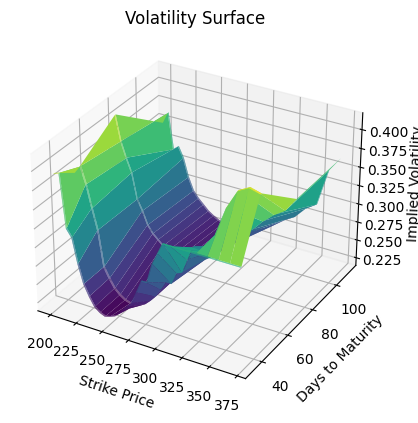

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create meshgrid for plotting
X, Y = meshgrid(strikes, maturities)

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Labeling
ax.set_xlabel('Strike Price')
ax.set_ylabel('Days to Maturity')
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface')

plt.show()